# Music Recommendation using Amazon SageMaker

Creating the perfect personalized musical playlist with Amazon SageMaker.

![](https://drive.google.com/uc?id=1etosTC-FSO_qpbERZ3sXZobav4hvUBb3&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

## Setup

In [ ]:
# install tree command (helpful in printing folder structures)
!apt-get install tree

# setup AWS cli
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/d01_admin/* ~/.aws
!chmod 600 ~/.aws/credentials
!pip install awscli

# install boto3 and sagemaker
!pip install boto3
!pip install sagemaker

# install dependencies
!pip install pyathena
!pip install awswrangler
!pip install smclarify
!pip install sagemaker-experiments
!pip install sagemaker-tensorflow
!pip install smclarify
!pip install stepfunctions
!pip install imbalanced-learn
!pip install smdebug

# install nlp libs
!pip install transformers

In [102]:
# imports
import boto3
import sagemaker
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import io
import os
import sys
import time
import datetime
import string
import json
import csv
import pathlib
import h5py
import zipfile
from tqdm.auto import tqdm
import uuid

import awswrangler as wr

from scipy.sparse import csr_matrix, hstack, save_npz, load_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import sagemaker.amazon.common as smac
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import JSONSerializer
from sagemaker.multidatamodel import MultiDataModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.lineage import context, artifact, association, action
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.xgboost.estimator import XGBoost
from awscli.customizations.s3.utils import split_s3_bucket_key

In [88]:
# global variables
role = "sagemakerRole"
prefix = "sagemaker-exp12061030"
training_instance_type = "ml.m5.xlarge"

In [171]:
# setup sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role_arn = "arn:aws:iam::{}:role/{}".format(account_id, role)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3_client = boto3.Session().client(service_name="s3", region_name=region)
sm_client = boto3.client("sagemaker", region_name=region)
runtime = boto3.Session().client(service_name='runtime.sagemaker')
runtime_sm_client = boto3.client('sagemaker-runtime')
boto_session = boto3.Session(region_name=region)
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sm
)

## Data Ingest

In [74]:
os.makedirs('data', exist_ok=True)

In [73]:
def get_data(s3_client, public_s3_data, to_bucket, to_prefix, sample_data=1):
    new_paths = []
    for f in public_s3_data:
        bucket_name, key_name = split_s3_bucket_key(f)
        filename = f.split('/')[-1]
        new_path = "s3://{}/{}/{}".format(to_bucket, to_prefix, filename)
        new_paths.append(new_path)
        
        # only download if not already downloaded
        if not os.path.exists('./data/{}'.format(filename)):
            # download s3 data
            print("Downloading file from {}".format(f))
            s3_client.download_file(bucket_name, key_name, './data/{}'.format(filename))
    
        # subsample the data to create a smaller datatset for this demo
        new_df = pd.read_csv('./data/{}'.format(filename))
        new_df = new_df.sample(frac=sample_data)
        new_df.to_csv('./data/{}'.format(filename), index=False)
        
        # upload s3 data to our default s3 bucket for SageMaker Studio
        print("Uploading {} to {}\n".format(filename, new_path))
        s3_client.upload_file('./data/{}'.format(filename), to_bucket, os.path.join(to_prefix,filename))
        
    return new_paths

In [75]:
# public S3 bucket that contains our music data
s3_bucket_music_data = "s3://sagemaker-sample-files/datasets/tabular/synthetic-music"

new_data_paths = get_data(
    s3_client,
    [f"{s3_bucket_music_data}/tracks.csv", f"{s3_bucket_music_data}/ratings.csv"],
    bucket,
    prefix,
    sample_data=0.70,
)
print(new_data_paths)

Uploading tracks.csv to s3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/tracks.csv

Uploading ratings.csv to s3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/ratings.csv

['s3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/tracks.csv', 's3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/ratings.csv']


In [90]:
# these are the new file paths located on your SageMaker Studio default s3 storage bucket
tracks_data_source = f"s3://{bucket}/{prefix}/tracks.csv"
ratings_data_source = f"s3://{bucket}/{prefix}/ratings.csv"

Update the Data Source in the .flow File


The `01_music_dataprep.flow` file is a JSON file containing instructions for where to find your data sources and how to transform the data. We'll be updating the object telling Data Wrangler where to find the input data on S3. We will set this to your default S3 bucket. With this update to the `.flow` file it now points to your new S3 bucket as the data source used by SageMaker Data Wrangler.

Make sure the `.flow` file is closed before running this next step or it won't update the new s3 file locations in the file

In [85]:
def update_data_sources(flow_path, tracks_data_source, ratings_data_source):
    with open(flow_path) as flowf:
        flow = json.load(flowf)
        
    for node in flow['nodes']:
        # if the key exists for our s3 endpoint
        try:
            if node['parameters']['dataset_definition']['name'] == 'tracks.csv':
                # reset the s3 data source for tracks data
                old_source = node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri']
                print("Changed {} to {}".format(old_source, tracks_data_source))
                node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri'] = tracks_data_source
            elif node['parameters']['dataset_definition']['name'] == 'ratings.csv':
                # reset the s3 data source for ratings data
                old_source = node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri']
                print("Changed {} to {}".format(old_source, ratings_data_source))
                node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri'] = ratings_data_source
        except:
            continue
    # write out the updated json flow file
    with open(flow_path, 'w') as outfile:
        json.dump(flow, outfile)
    
    return flow

In [86]:
!wget -q --show-progress https://github.com/recohut/sagemaker/raw/main/end_to_end/music_recommendation/01_music_dataprep.flow
update_data_sources("01_music_dataprep.flow", tracks_data_source, ratings_data_source)

01_music_dataprep.f 100%[===================>]  10.61K  --.-KB/s    in 0s      
Changed s3://sagemaker-us-east-2-xxxxxx/music-recommendation/tracks.csv to s3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/tracks.csv
Changed s3://sagemaker-us-east-2-xxxxxx/music-recommendation/ratings.csv to s3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/ratings.csv


{'metadata': {'disable_limits': False, 'version': 1},
 'nodes': [{'inputs': [],
   'node_id': '5c9d4f98-dd8a-4b74-89ad-735638aa7fe6',
   'operator': 'sagemaker.s3_source_0.1',
   'outputs': [{'name': 'default',
     'sampling': {'limit_rows': 50000, 'sampling_method': 'sample_by_limit'}}],
   'parameters': {'dataset_definition': {'__typename': 'S3CreateDatasetDefinitionOutput',
     'datasetSourceType': 'S3',
     'description': None,
     'name': 'tracks.csv',
     's3ExecutionContext': {'__typename': 'S3ExecutionContext',
      's3ContentType': 'csv',
      's3HasHeader': True,
      's3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/tracks.csv'}}},
   'type': 'SOURCE'},
  {'inputs': [{'name': 'default',
     'node_id': '5c9d4f98-dd8a-4b74-89ad-735638aa7fe6',
     'output_name': 'default'}],
   'node_id': 'd6154703-6fe5-4501-bf0a-568d2ef32974',
   'operator': 'sagemaker.spark.infer_and_cast_type_0.1',
   'outputs': [{'name': 'default'}],
   'parameters': {},
   'tr

## Explore the Data

In [91]:
tracks = pd.read_csv("./data/tracks.csv")
ratings = pd.read_csv("./data/ratings.csv")

In [92]:
tracks.head()

,trackId,length,energy,acousticness,valence,speechiness,instrumentalness,liveness,tempo,genre
0,bae72e9d-b4b4-482f-a49b-6b76f667c874,174.0,0.355396,0.845407,0.275824,0.022800,0.000000,0.082695,109.723293,Reggae
1,a3d5fb70-3739-4242-bdf8-706737f048fa,428.0,0.550642,0.088523,0.513778,0.045317,0.000000,0.158149,122.046987,RnB
2,3db3e515-64b3-431c-8d6f-d66619260349,202.0,0.999000,0.014539,0.285010,0.170163,0.000000,0.302054,89.198689,Latin
3,72b3b004-bba2-443e-851f-8a0f556c8aff,213.0,0.376102,0.773279,0.426179,0.093068,0.094071,0.075710,131.733421,Folk
4,6325aea8-4fe4-43bb-b0a4-d5106617b0ba,93.0,0.737811,0.418429,0.811016,0.049585,0.199617,0.286710,148.204637,Latin


In [93]:
ratings.head()

,ratingEventId,ts,userId,trackId,sessionId,itemInSession,Rating
0,ac6533cb-9d75-43b8-9d86-0005a0715aac,1593766534,11214,b0fa196e-42dd-4839-aef1-cd975db27933,12653,249,5.0
1,fb95a668-18c8-4452-8ce3-8396319c3953,1581269267,11022,6a91c9fc-fd9d-4fa4-8061-8e41324fc166,6376,55,4.0
2,82b2571b-447e-461b-ba62-bce93bc70bb5,1579111303,11169,1d464ecc-575d-41a3-9956-77fbd58f572c,5524,66,1.0
3,1ae587bd-6efb-4ad0-9eae-f1fd1ce80356,1576522008,11139,f16aaf51-50d9-4b03-a68f-3116ba0b0c3c,3861,3,3.0
4,79032f0b-211f-4413-8b01-ff1c85a8fb94,1589384811,11228,aa00c167-6da3-46ab-81d2-c59a54369bda,10940,31,4.0


In [94]:
print("{:,} different songs/tracks".format(tracks["trackId"].nunique()))
print("{:,} users".format(ratings["userId"].nunique()))
print("{:,} user rating events".format(ratings["ratingEventId"].nunique()))

140,291 different songs/tracks
258 users
700,000 user rating events


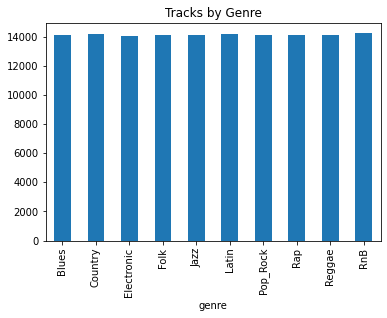

In [95]:
tracks.groupby("genre")["genre"].count().plot.bar(title="Tracks by Genre");

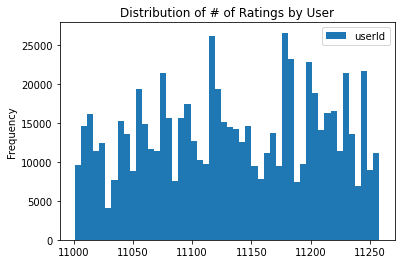

In [96]:
ratings[["ratingEventId", "userId"]].plot.hist(
    by="userId", bins=50, title="Distribution of # of Ratings by User"
)

Create some new data to ingest later

In [97]:
tracks_new = tracks[:300]
ratings_new = ratings[:1000]

# export dataframes to csv
tracks_new.to_csv("./data/tracks_new.csv", index=False)
ratings_new.to_csv("./data/ratings_new.csv", index=False)

In [98]:
s3_client.upload_file(
    Filename="./data/tracks_new.csv", Bucket=bucket, Key=f"{prefix}/data/tracks_new.csv"
)
s3_client.upload_file(
    Filename="./data/ratings_new.csv", Bucket=bucket, Key=f"{prefix}/data/ratings_new.csv"
)

## Create Feature Group

Define Feature Group

In [99]:
# feature group name, with flow_name and an unique id. You can give it a customized name
feature_group_names = [
    "track-features-music-rec",
    "user-5star-track-features-music-rec",
    "ratings-features-music-rec",
]
print(f"Feature Group Name: {feature_group_names}")

record_identifier_feature_names = {
    "track-features-music-rec": "trackId",
    "user-5star-track-features-music-rec": "userId",
    "ratings-features-music-rec": "ratingEventId",
}
event_time_feature_name = "EventTime"

Feature Group Name: ['track-features-music-rec', 'user-5star-track-features-music-rec', 'ratings-features-music-rec']


Feature Definitions

The following is a list of the feature names and data types of the final dataset that will be produced when your data flow is used to process your input dataset.

In [100]:
track_column_schemas = [
    {"name": "trackId", "type": "string"},
    {"name": "length", "type": "float"},
    {"name": "energy", "type": "float"},
    {"name": "acousticness", "type": "float"},
    {"name": "valence", "type": "float"},
    {"name": "speechiness", "type": "float"},
    {"name": "instrumentalness", "type": "float"},
    {"name": "liveness", "type": "float"},
    {"name": "tempo", "type": "float"},
    {"name": "genre_Folk", "type": "float"},
    {"name": "genre_Country", "type": "float"},
    {"name": "genre_Latin", "type": "float"},
    {"name": "genre_Jazz", "type": "float"},
    {"name": "genre_RnB", "type": "float"},
    {"name": "genre_Reggae", "type": "float"},
    {"name": "genre_Rap", "type": "float"},
    {"name": "genre_Pop_Rock", "type": "float"},
    {"name": "genre_Electronic", "type": "float"},
    {"name": "genre_Blues", "type": "float"},
    {"name": "danceability", "type": "float"},
    {"name": "EventTime", "type": "float"},
]

user_column_schemas = [
    {"name": "userId", "type": "long"},
    {"name": "energy_5star", "type": "float"},
    {"name": "acousticness_5star", "type": "float"},
    {"name": "valence_5star", "type": "float"},
    {"name": "speechiness_5star", "type": "float"},
    {"name": "instrumentalness_5star", "type": "float"},
    {"name": "liveness_5star", "type": "float"},
    {"name": "tempo_5star", "type": "float"},
    {"name": "danceability_5star", "type": "float"},
    {"name": "genre_Latin_5star", "type": "float"},
    {"name": "genre_Folk_5star", "type": "float"},
    {"name": "genre_Blues_5star", "type": "float"},
    {"name": "genre_Rap_5star", "type": "float"},
    {"name": "genre_Reggae_5star", "type": "float"},
    {"name": "genre_Jazz_5star", "type": "float"},
    {"name": "genre_RnB_5star", "type": "float"},
    {"name": "genre_Country_5star", "type": "float"},
    {"name": "genre_Electronic_5star", "type": "float"},
    {"name": "genre_Pop_Rock_5star", "type": "float"},
    {"name": "EventTime", "type": "float"},
]

rating_column_schemas = [
    {"name": "ratingEventId", "type": "string"},
    {"name": "ts", "type": "long"},
    {"name": "userId", "type": "long"},
    {"name": "trackId", "type": "string"},
    {"name": "sessionId", "type": "long"},
    {"name": "itemInSession", "type": "long"},
    {"name": "Rating", "type": "float"},
    {"name": "EventTime", "type": "float"},
]

column_schemas = {
    "track-features-music-rec": track_column_schemas,
    "user-5star-track-features-music-rec": user_column_schemas,
    "ratings-features-music-rec": rating_column_schemas,
}

Below we create the SDK input for those feature definitions. Some schema types in Data Wrangler are not supported by Feature Store. The following will create a default_FG_type set to String for these types.

In [101]:
from sagemaker.feature_store.feature_definition import FeatureDefinition
from sagemaker.feature_store.feature_definition import FeatureTypeEnum

default_feature_type = FeatureTypeEnum.STRING
column_to_feature_type_mapping = {
    "float": FeatureTypeEnum.FRACTIONAL,
    "long": FeatureTypeEnum.INTEGRAL,
}

feature_definitions = {}

for feature_group_name in feature_group_names:
    feature_definition = [
        FeatureDefinition(
            feature_name=column_schema["name"],
            feature_type=column_to_feature_type_mapping.get(
                column_schema["type"], default_feature_type
            ),
        )
        for column_schema in column_schemas[feature_group_name]
    ]
    feature_definitions[feature_group_name] = feature_definition

Configure Feature Group

In [104]:
# flow name and an unique ID for this export (used later as the processing job name for the export)
flow_name = "01_music_dataprep"
flow_export_id = f"{time.strftime('%d-%H-%M-%S', time.gmtime())}-{str(uuid.uuid4())[:8]}"
flow_export_name = f"flow-{flow_export_id}"

# SageMaker FeatureStore writes the data in the OfflineStore of a FeatureGroup to a
# S3 location owned by you.
feature_store_offline_s3_uri = "s3://" + bucket

# controls if online store is enabled. Enabling the online store allows quick access to
# the latest value for a Record via the GetRecord API.
enable_online_store = True
fg_name_tracks = feature_group_name

Initialize & Create Feature Group

In [106]:
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

feature_store_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

In [109]:
def wait_for_feature_group_creation_complete(feature_group):
    """Helper function to wait for the completions of creating a feature group"""
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise SystemExit(f"Failed to create feature group {feature_group.name}: {status}")
    print(f"FeatureGroup {feature_group.name} successfully created.")


def create_feature_group(feature_group_name, feature_store_session, feature_definitions):
    feature_group = FeatureGroup(
        name=feature_group_name,
        sagemaker_session=feature_store_session,
        feature_definitions=feature_definitions[feature_group_name],
    )

    # only create feature group if it doesn't already exist
    try:
        sagemaker_client.describe_feature_group(
            FeatureGroupName=feature_group_name, NextToken="string"
        )
        feature_group_exists = True
        print("Feature Group {0} already exists. Using {0}".format(feature_group_name))
    except Exception as e:
        error = e.response.get("Error").get("Code")
        if error == "ResourceNotFound":
            feature_group_exists = False
            print("Creating Feature Group {}".format(feature_group_name))
            feature_group.create(
                s3_uri=feature_store_offline_s3_uri,
                record_identifier_name=record_identifier_feature_names[feature_group_name],
                event_time_feature_name=event_time_feature_name,
                role_arn=role_arn,
                enable_online_store=enable_online_store,
            )
            # Invoke the Feature Store API to create the feature group and wait until it is ready
            wait_for_feature_group_creation_complete(feature_group=feature_group)
        if error == "ResourceInUse":
            feature_group_exists = True
            print("Feature Group {0} already exists. Using {0}".format(feature_group_name))

    return feature_group_exists

In [110]:
feature_group_existence = {}
for feature_group_name in feature_group_names:
    feature_group_exists = create_feature_group(
        feature_group_name, feature_store_session, feature_definitions
    )
    feature_group_existence[feature_group_name] = feature_group_exists

Creating Feature Group track-features-music-rec
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup track-features-music-rec successfully created.
Creating Feature Group user-5star-track-features-music-rec
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup user-5star-track-features-music-rec successfully created.
Creating Feature Group ratings-features-music-rec
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup ratings-features-music-rec successfully created.


![](https://drive.google.com/uc?id=1euFcxwcTubOpZVIEdIVa5W3t0Ei66ymV&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

## Data Processing

Input sources

In [112]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.dataset_definition.inputs import (
    AthenaDatasetDefinition,
    DatasetDefinition,
    RedshiftDatasetDefinition,
)

data_sources = []

data_sources.append(
    ProcessingInput(
        source=f"{tracks_data_source}",  # You could override this to point to another dataset on S3
        destination="/opt/ml/processing/tracks.csv",
        input_name="tracks.csv",
        s3_data_type="S3Prefix",
        s3_input_mode="File",
        s3_data_distribution_type="FullyReplicated",
    )
)

data_sources.append(
    ProcessingInput(
        source=f"{ratings_data_source}",  # You could override this to point to another dataset on S3
        destination="/opt/ml/processing/ratings.csv",
        input_name="ratings.csv",
        s3_data_type="S3Prefix",
        s3_input_mode="File",
        s3_data_distribution_type="FullyReplicated",
    )
)

Output: Feature Store

Below are the inputs required by the SageMaker Python SDK to launch a processing job with feature store as an output. Notice the output_name variable below; this ID is found within the .flow file at the node point you want to capture transformations up to. The .flow file contains instructions for SageMaker Data Wrangler to know where to look for data and how to transform it. Each data transformation action is associated with a node and therefore a node ID. Using the associated node ID + output name tells SageMaker up to what point in the transformation process you want to export to a feature store.

In [113]:
from sagemaker.processing import FeatureStoreOutput

# Output name is auto-generated from the select node's ID + output name from the .flow file
output_names = {
    "track-features-music-rec": "19ad8e80-2002-4ee9-9753-fe9a384b1166.default",
    "user-5star-track-features-music-rec": "7a6dad19-2c80-43e3-b03d-ec23c3842ae9.default",
    "ratings-features-music-rec": "9a283380-91ca-478e-be99-6ba3bf57c680.default",
}

processing_job_outputs = {}

for feature_group_name in feature_group_names:
    processing_job_output = ProcessingOutput(
        output_name=output_names[feature_group_name],
        app_managed=True,
        feature_store_output=FeatureStoreOutput(feature_group_name=feature_group_name),
    )
    processing_job_outputs[feature_group_name] = processing_job_output

Upload Flow to S3

To use the Data Wrangler as an input to the processing job, first upload your flow file to Amazon S3.

In [114]:
# name of the flow file which should exist in the current notebook working directory
flow_file_name = "01_music_dataprep.flow"

# Load .flow file from current notebook working directory
!echo "Loading flow file from current notebook working directory: $PWD"

with open(flow_file_name) as f:
    flow = json.load(f)

# Upload flow to S3
s3_client = boto3.client("s3")
s3_client.upload_file(
    flow_file_name, bucket, f"{prefix}/data_wrangler_flows/{flow_export_name}.flow"
)

flow_s3_uri = f"s3://{bucket}/{prefix}/data_wrangler_flows/{flow_export_name}.flow"

print(f"Data Wrangler flow {flow_file_name} uploaded to {flow_s3_uri}")

Loading flow file from current notebook working directory: /content/tmp
Data Wrangler flow 01_music_dataprep.flow uploaded to s3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/data_wrangler_flows/flow-12-09-02-18-dfad5d6c.flow


The Data Wrangler Flow is also provided to the Processing Job as an input source which we configure below.

In [115]:
## Input - Flow: 01_music_dataprep.flow
flow_input = ProcessingInput(
    source=flow_s3_uri,
    destination="/opt/ml/processing/flow",
    input_name="flow",
    s3_data_type="S3Prefix",
    s3_input_mode="File",
    s3_data_distribution_type="FullyReplicated",
)

Create Processing Job

In [116]:
from sagemaker.processing import Processor
from sagemaker.network import NetworkConfig

# Data Wrangler Container URL.
container_uri = sagemaker.image_uris.retrieve(framework="data-wrangler", region=region)

# Processing Job Instance count and instance type.
instance_count = 2
instance_type = "ml.m5.4xlarge"

# Size in GB of the EBS volume to use for storing data during processing
volume_size_in_gb = 30

# Content type for each output. Data Wrangler supports CSV as default and Parquet.
output_content_type = "CSV"

# Network Isolation mode; default is off
enable_network_isolation = False

processor = Processor(
    role=role_arn,
    image_uri=container_uri,
    instance_count=instance_count,
    instance_type=instance_type,
    volume_size_in_gb=volume_size_in_gb,
    network_config=NetworkConfig(enable_network_isolation=enable_network_isolation),
    sagemaker_session=sess,
)

Job Status & S3 Output Location

Below you wait for processing job to finish. If it finishes successfully, your feature group should be populated with transformed feature values. In addition the raw parameters used by the Processing Job will be printed.

In [117]:
%%time

feature_group_exists = False
for feature_group_name in feature_group_names:
    print(f"Processing {feature_group_name}")
    # Unique processing job name. Give a unique name every time you re-execute processing jobs
    processing_job_name = "dw-flow-proc-music-rec-tracks-{}-{}".format(
        flow_export_id, str(uuid.uuid4())[:8]
    )
    print(f"{processing_job_name}")

    # Output configuration used as processing job container arguments
    output_config = {output_names[feature_group_name]: {"content_type": output_content_type}}

    # Run Processing Job if job not already previously ran
    if feature_group_exists:  # feature_group_existence[feature_group_name]
        print(
            "Feature Group {0} already exists therefore we will not run a processing job to create it again".format(
                feature_group_name
            )
        )
    else:
        print("Creating Processing Job: {}".format(feature_group_name))
        processor.run(
            inputs=[flow_input] + data_sources,
            outputs=[processing_job_outputs[feature_group_name]],
            arguments=[f"--output-config '{json.dumps(output_config)}'"],
            wait=False,
            logs=False,
            job_name=processing_job_name,
        )

        job_result = sess.wait_for_processing_job(processing_job_name)
        print(job_result)

Processing track-features-music-rec
dw-flow-proc-music-rec-tracks-12-09-02-18-dfad5d6c-1fb996fe
Creating Processing Job: track-features-music-rec

Job Name:  dw-flow-proc-music-rec-tracks-12-09-02-18-dfad5d6c-1fb996fe
Inputs:  [{'InputName': 'flow', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/data_wrangler_flows/flow-12-09-02-18-dfad5d6c.flow', 'LocalPath': '/opt/ml/processing/flow', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'tracks.csv', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/tracks.csv', 'LocalPath': '/opt/ml/processing/tracks.csv', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'ratings.csv', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/sage

![](https://drive.google.com/uc?id=1ev2TRZyPAVMlW0cpnNq1VEOaTKV3rU6n&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

## Fetch Data from Offline Feature Store

There are 3 feature stores for the ratings, tracks, and user preferences data. We retrieve data from all 3 before joining them.

In [118]:
feature_groups = []
for name in feature_group_names:
    feature_group = FeatureGroup(name=name, sagemaker_session=feature_store_session)
    feature_groups.append(feature_group)

In [119]:
s3_output_path = "s3://" + bucket

In [120]:
feature_group_s3_prefixes = []
for feature_group in feature_groups:
    feature_group_table_name = (
        feature_group.describe().get("OfflineStoreConfig").get("DataCatalogConfig").get("TableName")
    )
    feature_group_s3_prefix = (
        f"{account_id}/sagemaker/{region}/offline-store/{feature_group_table_name}"
    )
    feature_group_s3_prefixes.append(feature_group_s3_prefix)

In [121]:
# wait for data to be added to offline feature store
def wait_for_offline_store(feature_group_s3_prefix):
    print(feature_group_s3_prefix)
    offline_store_contents = None
    while offline_store_contents is None:
        objects_in_bucket = s3_client.list_objects(Bucket=bucket, Prefix=feature_group_s3_prefix)
        if "Contents" in objects_in_bucket and len(objects_in_bucket["Contents"]) > 1:
            offline_store_contents = objects_in_bucket["Contents"]
        else:
            print("Waiting for data in offline store...")
            time.sleep(60)
    print("Data available.")


for s3_prefix in feature_group_s3_prefixes:
    wait_for_offline_store(s3_prefix)

390354360073/sagemaker/us-east-1/offline-store/track-features-music-rec-1655024766
Data available.
390354360073/sagemaker/us-east-1/offline-store/user-5star-track-features-music-rec-1655024787
Data available.
390354360073/sagemaker/us-east-1/offline-store/ratings-features-music-rec-1655024813
Data available.


In [122]:
tables = {
    "ratings": {"feature_group": feature_groups[2], "cols": ["userId", "trackid", "rating"]},
    "tracks": {
        "feature_group": feature_groups[0],
        "cols": [
            "trackid",
            "length",
            "energy",
            "acousticness",
            "valence",
            "speechiness",
            "instrumentalness",
            "liveness",
            "tempo",
            "danceability",
            "genre_latin",
            "genre_folk",
            "genre_blues",
            "genre_rap",
            "genre_reggae",
            "genre_jazz",
            "genre_rnb",
            "genre_country",
            "genre_electronic",
            "genre_pop_rock",
        ],
    },
    "user_5star_features": {
        "feature_group": feature_groups[1],
        "cols": [
            "userId",
            "energy_5star",
            "acousticness_5star",
            "valence_5star",
            "speechiness_5star",
            "instrumentalness_5star",
            "liveness_5star",
            "tempo_5star",
            "danceability_5star",
            "genre_latin_5star",
            "genre_folk_5star",
            "genre_blues_5star",
            "genre_rap_5star",
            "genre_reggae_5star",
            "genre_jazz_5star",
            "genre_rnb_5star",
            "genre_country_5star",
            "genre_electronic_5star",
            "genre_pop_rock_5star",
        ],
    },
}

Check if the Athena queries have been done and the data sets exist, then just do train test split or just proceed to training

In [123]:
def get_train_val():
    for k, v in tables.items():
        query = v["feature_group"].athena_query()
        joined_cols = ", ".join(v["cols"])
        # limit number of datapoints for training time
        query_string = 'SELECT {} FROM "{}" LIMIT 500000'.format(joined_cols, query.table_name)
        print(query_string, "\n")

        output_location = f"s3://{bucket}/{prefix}/query_results/"
        query.run(query_string=query_string, output_location=output_location)
        query.wait()

        tables[k]["df"] = query.as_dataframe()

    ratings = tables["ratings"]["df"]
    tracks = tables["tracks"]["df"]
    user_prefs = tables["user_5star_features"]["df"]

    print("Merging datasets...")
    print(f"Ratings: {ratings.shape}\nTracks: {tracks.shape}\nUser Prefs: {user_prefs.shape}\n")

    dataset = pd.merge(ratings, tracks, on="trackid", how="inner")
    dataset = pd.merge(dataset, user_prefs, on="userId", how="inner")
    dataset.drop_duplicates(inplace=True)
    dataset.drop(["userId", "trackid"], axis=1, inplace=True)

    # split data
    from sklearn.model_selection import train_test_split

    train, val = train_test_split(dataset, test_size=0.2, random_state=42)
    print(
        "Training dataset shape: {}\nValidation dataset shape: {}\n".format(train.shape, val.shape)
    )

    return train, val

In [124]:
%%time
print("Creating training and validation sets...\n")
train, val = get_train_val()
# Write to csv in S3 without headers and index column
train.to_csv("./data/train_data.csv", header=False, index=False)
val.to_csv("./data/val_data.csv", header=False, index=False)

pd.DataFrame({"ColumnName": train.columns}).to_csv(
    "./data/train_data_headers.csv", header=False, index=False
)
pd.DataFrame({"ColumnName": val.columns}).to_csv(
    "./data/val_data_headers.csv", header=False, index=False
)

Creating training and validation sets...

SELECT userId, trackid, rating FROM "ratings-features-music-rec-1655024813" LIMIT 500000 

SELECT trackid, length, energy, acousticness, valence, speechiness, instrumentalness, liveness, tempo, danceability, genre_latin, genre_folk, genre_blues, genre_rap, genre_reggae, genre_jazz, genre_rnb, genre_country, genre_electronic, genre_pop_rock FROM "track-features-music-rec-1655024766" LIMIT 500000 

SELECT userId, energy_5star, acousticness_5star, valence_5star, speechiness_5star, instrumentalness_5star, liveness_5star, tempo_5star, danceability_5star, genre_latin_5star, genre_folk_5star, genre_blues_5star, genre_rap_5star, genre_reggae_5star, genre_jazz_5star, genre_rnb_5star, genre_country_5star, genre_electronic_5star, genre_pop_rock_5star FROM "user-5star-track-features-music-rec-1655024787" LIMIT 500000 

Merging datasets...
Ratings: (500000, 3)
Tracks: (141182, 20)
User Prefs: (258, 19)

Training dataset shape: (268806, 38)
Validation datase

Save data to S3

In [125]:
%%time

train_headers = pd.read_csv("data/train_data_headers.csv", header=None)[0].tolist()
val_headers = pd.read_csv("data/val_data_headers.csv", header=None)[0].tolist()
train = pd.read_csv("data/train_data.csv", names=train_headers)
val = pd.read_csv("data/val_data.csv", names=val_headers)

s3_client.upload_file("data/train_data.csv", bucket, f"{prefix}/data/train/train_data.csv")
s3_client.upload_file("data/val_data.csv", bucket, f"{prefix}/data/val/val_data.csv")


train_data_uri = f"s3://{bucket}/{prefix}/data/train/train_data.csv"
val_data_uri = f"s3://{bucket}/{prefix}/data/val/val_data.csv"
print(f"Saving training data to {train_data_uri}")

# configure data inputs for SageMaker training
from sagemaker.inputs import TrainingInput

train_input = TrainingInput(train_data_uri, content_type="text/csv")
val_input = TrainingInput(val_data_uri, content_type="text/csv")

Saving training data to s3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/data/train/train_data.csv
CPU times: user 3.31 s, sys: 877 ms, total: 4.19 s
Wall time: 7.8 s


## Model Train

In [128]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator

In [131]:
# variables used for parameterizing the notebook run
estimator_output_path = f"s3://{bucket}/{prefix}/training_jobs"
train_instance_count = 2
train_instance_type = "ml.m5.4xlarge"
save_interval = 2
image = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")
model_name = "music-rec-model-{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

hyperparameters = {
    "max_depth": "4",
    "eta": "0.2",
    "objective": "reg:squarederror",
    "num_round": "100",
}

In [132]:
xgb_estimator = Estimator(
    role=role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    image_uri=image,
    hyperparameters=hyperparameters,
    output_path=estimator_output_path,
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=estimator_output_path + "/debugger",
        collection_configs=[
            CollectionConfig(name="metrics", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": str(save_interval)}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(name="average_shap", parameters={"save_interval": str(save_interval)}),
        ],
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        )
    ],
)

In [133]:
response = sagemaker_client.list_training_jobs(
    NameContains=model_name, StatusEquals="Completed", SortBy="CreationTime", SortOrder="Descending"
)

In [134]:
%%time

train_model = True  # True if training a new model, False if wanting to use an existing estimator once you've already trained

if train_model:
    print("Training the model")
    xgb_estimator.fit(inputs={"train": train_input, "validation": val_input}, job_name=model_name)
    s3_debugger_output_path = xgb_estimator.latest_job_debugger_artifacts_path()
elif len(response["TrainingJobSummaries"]) > 0:
    training_job_name = response["TrainingJobSummaries"][0]["TrainingJobName"]
    xgb_estimator = Estimator.attach(training_job_name)
    s3_debugger_output_path = xgb_estimator.latest_job_debugger_artifacts_path()
else:
    print("No existing estimator found. You'll need to run as train = True")

Training the model
2022-06-12 09:45:29 Starting - Starting the training job...LossNotDecreasing: InProgress
ProfilerReport-1655027129: InProgress
...
2022-06-12 09:46:20 Starting - Preparing the instances for training.........
2022-06-12 09:47:53 Downloading - Downloading input data...
2022-06-12 09:48:34 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[09:48:28] 268806x37 matrix with 9945822 entries loaded from /opt/ml/input/data/train?format=csv&label_co

In [135]:
training_job_name = xgb_estimator.latest_training_job.job_name
print(training_job_name)

music-rec-model-20220612-094437


In [136]:
import pprint

training_job_info = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
pprint.pprint(f"{training_job_info}")

("{'TrainingJobName': 'music-rec-model-20220612-094437', 'TrainingJobArn': "
 "'arn:aws:sagemaker:us-east-1:390354360073:training-job/music-rec-model-20220612-094437', "
 "'ModelArtifacts': {'S3ModelArtifacts': "
 "'s3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/training_jobs/music-rec-model-20220612-094437/output/model.tar.gz'}, "
 "'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', "
 "'HyperParameters': {'eta': '0.2', 'max_depth': '4', 'num_round': '100', "
 "'objective': 'reg:squarederror'}, 'AlgorithmSpecification': "
 "{'TrainingImage': "
 "'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3', "
 "'TrainingInputMode': 'File', 'MetricDefinitions': [{'Name': 'train:mae', "
 "'Regex': "
 "'.*\\\\[[0-9]+\\\\].*#011train-mae:([-+]?[0-9]*\\\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'}, "
 "{'Name': 'train:gamma-nloglik', 'Regex': "
 "'.*\\\\[[0-9]+\\\\].*#011train-gamma-nloglik:([-+]?[0-9]*\\\\.?[0-9]+(?:[eE][-+]?[0-9]+)?).*'}, "
 "{'Name': 

![](https://drive.google.com/uc?id=1ewy7ACoVh97qUXk6dsBrZZkbQIgfEJON&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

## Model Deploy

In [138]:
endpoint_name = "music-rec-endpoint-{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(endpoint_name)

music-rec-endpoint-20220612-095854


In [139]:
%%time
# deploy endpoint for model if it doesn't already exist
xgb_estimator.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", endpoint_name=endpoint_name
)

--------!CPU times: user 920 ms, sys: 97.4 ms, total: 1.02 s
Wall time: 4min 3s


In [141]:
predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint_name, sagemaker_session=sess
)

In [143]:
# public S3 bucket that contains our music data
s3_bucket_music_data = "s3://sagemaker-sample-files/datasets/tabular/synthetic-music"

files_to_download = [
    f"sample_tracks.csv",
    f"sample_user.csv"
]

for file in files_to_download:
    s3_client.download_file(
        f"sagemaker-sample-files", f"datasets/tabular/synthetic-music/{file}", f"./data/{file}"
    )

In [144]:
# Pull user data from feature group
df_user = pd.read_csv("./data/sample_user.csv")
df_user = df_user.set_index("FeatureName")

# Pull sample of 1000 tracks from feature group
df_tracks = pd.read_csv("./data/sample_tracks.csv")

feature_names = pd.read_csv("data/train_data_headers.csv", header=None)[0].tolist()[1:]
data = (
    df_tracks.assign(key=1)
    .merge(pd.DataFrame(df_user["ValueAsString"]).T.assign(key=1), on="key")
    .drop("key", axis=1)
)
data.columns = [c.lower() for c in data.columns]
inference_df = data[feature_names]
inference_df

,length,energy,acousticness,valence,speechiness,instrumentalness,liveness,tempo,danceability,genre_latin,...,genre_latin_5star,genre_folk_5star,genre_blues_5star,genre_rap_5star,genre_reggae_5star,genre_jazz_5star,genre_rnb_5star,genre_country_5star,genre_electronic_5star,genre_pop_rock_5star
0,206.0,0.818128,0.014651,0.537532,0.098600,0.000000,0.050934,142.273122,0.248166,0.0,...,0.071429,0.142857,0.285714,0.0,0.142857,0.071429,0.0,0.0,0.071429,0.214286
1,165.0,0.600423,0.603969,0.888047,0.118855,0.000000,0.076967,104.966775,0.334153,0.0,...,0.071429,0.142857,0.285714,0.0,0.142857,0.071429,0.0,0.0,0.071429,0.214286
2,220.0,0.648200,0.341644,0.333641,0.055448,0.000000,0.186962,87.601713,0.183608,0.0,...,0.071429,0.142857,0.285714,0.0,0.142857,0.071429,0.0,0.0,0.071429,0.214286
3,216.0,0.020247,0.843871,0.380408,0.063541,0.000000,0.512031,108.338442,0.167350,0.0,...,0.071429,0.142857,0.285714,0.0,0.142857,0.071429,0.0,0.0,0.071429,0.214286
4,214.0,0.999000,0.729299,0.923900,0.112069,0.026768,0.068583,120.320966,0.383928,0.0,...,0.071429,0.142857,0.285714,0.0,0.142857,0.071429,0.0,0.0,0.071429,0.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,129.0,0.999000,0.041529,0.707104,0.022800,0.000000,0.087255,175.209450,0.320757,0.0,...,0.071429,0.142857,0.285714,0.0,0.142857,0.071429,0.0,0.0,0.071429,0.214286
996,251.0,0.747009,0.070567,0.685785,0.041217,0.000000,0.099331,143.787126,0.290369,0.0,...,0.071429,0.142857,0.285714,0.0,0.142857,0.071429,0.0,0.0,0.071429,0.214286
997,300.0,0.445978,0.042812,0.539664,0.022800,0.042395,0.093210,78.582637,0.215818,0.0,...,0.071429,0.142857,0.285714,0.0,0.142857,0.071429,0.0,0.0,0.071429,0.214286
998,188.0,0.216382,0.569741,0.084572,0.022800,0.000000,0.100593,166.975235,0.057069,0.0,...,0.071429,0.142857,0.285714,0.0,0.142857,0.071429,0.0,0.0,0.071429,0.214286


Format the datapoint

The datapoint must match the exact input format as the model was trained--with all features in the correct order. In this example, the col_order variable was saved when you created the train and test datasets earlier in the guide.

In [145]:
data_inputs = [",".join([str(i) for i in row]) for row in inference_df.values]

![](https://drive.google.com/uc?id=1exFjB_pRXFNPA4urIOmGzdmUEZ5d-SsA&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

## Inference

Infer New Songs using Model

In [146]:
predictions = []
for data_input in data_inputs:
    results = predictor.predict(data_input, initial_args={"ContentType": "text/csv"})
    prediction = json.loads(results)
    predictions.append(prediction)
print(f"Predicted rating for sample user:", prediction)

Predicted rating for sample user: 3.0784361362457275


In [147]:
# Write to csv in S3 without headers and index column.
inference_df["rating"] = predictions
inference_df = inference_df[["rating"] + feature_names]
inference_df.to_csv("data/prediction_data.csv", header=False, index=False)

s3_client.upload_file("data/prediction_data.csv", bucket, f"{prefix}/data/pred/prediction_data.csv")

pred_data_uri = f"s3://{bucket}/{prefix}/data/pred/prediction_data.csv"

s3_client.download_file(bucket, f"{prefix}/data/train/train_data.csv", f"train_data.csv")
df_train = pd.read_csv("train_data.csv")

label = "rating"

## Explain Model Predictions

In [148]:
model = xgb_estimator.create_model(name=model_name)
container_def = model.prepare_container_def()
sess.create_model(model_name, role, container_def)

explainability_output_path = f"s3://{bucket}/{prefix}/clarify-output/explainability"

clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    sagemaker_session=sess,
)

model_config = sagemaker.clarify.ModelConfig(
    model_name=model_name, instance_type="ml.m4.xlarge", instance_count=1, accept_type="text/csv"
)

shap_config = sagemaker.clarify.SHAPConfig(
    baseline=[
        df_train.median().values[1:].tolist()
    ],  # ignore the first column since that is that target
    num_samples=100,
    agg_method="mean_abs",
)

explainability_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=pred_data_uri,
    s3_output_path=explainability_output_path,
    label=label,
    headers=[label] + feature_names,
    dataset_type="text/csv",
)

In [149]:
%%time
try:
    s3_client.download_file(
        Bucket=bucket,
        Key=f"{prefix}/clarify-output/explainability/explanations_shap/out.csv",
        Filename="data/shap_output.csv",
    )
    print("Downloaded output from previous explainability job")
except Exception as e:
    error = e.response.get("Error").get("Code")
    if error == "404":
        print("Running explainability job")
        clarify_processor.run_explainability(
            data_config=explainability_data_config,
            model_config=model_config,
            explainability_config=shap_config,
        )

Running explainability job

Job Name:  Clarify-Explainability-2022-06-12-10-33-14-574
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/data/pred/prediction_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/clarify-output/explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/clarify-output/explainability', 'LocalPath': '/opt/ml/processi

Curated Playlist:
 571    43fa4bf1-ae64-41c8-8eb0-2098143d26ce
972    c78cc8cf-e930-4a46-92d4-a66e49d57ec2
329    ae78d757-78ce-4cb2-ab22-cae7e5d335ca
342    bca34212-8364-4d98-93ee-f79ba17bc432
446    ec666939-8c29-4e32-9b78-7f30beb046b6
966    5828202f-85d0-4a2e-b78b-ac59a199c183
199    5f2202d0-a915-4ba1-92c5-5fde752c861f
809    d2bb0272-b428-4254-b340-5a682d0162e0
18     7cd80c65-ff6b-4b06-a8a8-4fe929993970
86     a5edff7e-dab7-4301-814d-9b8d04a25adb
Name: trackid, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Model prediction: 5.442928791046143


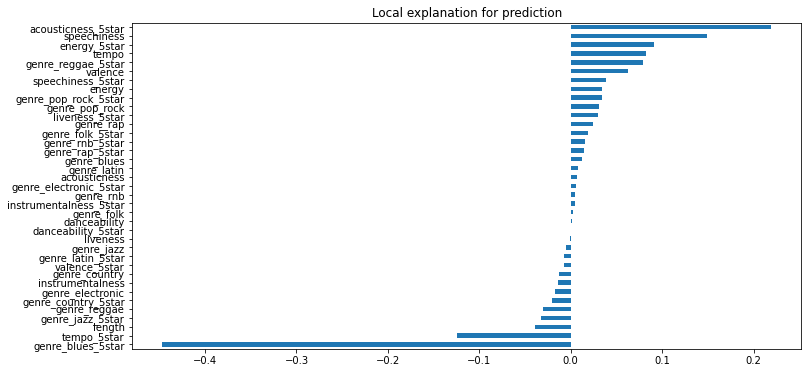

In [150]:
inference_df["trackid"] = data["trackid"]

playlist_length = 10  # number of songs to recommend in playlist
playlist = inference_df.sort_values(by="rating", ascending=False).head(playlist_length)
print("Curated Playlist:\n", playlist["trackid"])

s3_client.download_file(
    bucket, f"{prefix}/clarify-output/explainability/explanations_shap/out.csv", f"out.csv"
)
local_explanations_out = pd.read_csv("out.csv")
local_explanations_out.columns = feature_names

print("Model prediction:", playlist.iloc[0, 0])
plt.figure(figsize=(12, 6))
local_explanations_out.iloc[0].sort_values().plot.barh(title="Local explanation for prediction")

## View SageMaker Debugger Reports

A machine learning training job can have problems such as system bottlenecks, overfitting, saturated activation functions, and vanishing gradients, which can compromise model performance. SageMaker Debugger profiles and debugs training jobs to help resolve such problems and improve your ML model's compute resource utilization and performance. Debugger offers tools to send alerts when training anomalies are found, take actions against the problems, and identify the root cause of them by visualizing collected metrics and tensors.

Create the Trail for the Experiment uisng the Debugger to generate trial debug-output

In [154]:
%%time
from smdebug.trials import create_trial

try:
    trial = create_trial(s3_debugger_output_path)
except:
    parameters = ps.read("music-rec")
    s3_debugger_output_path = parameters["s3_debugger_output_path"]
    trial = create_trial(s3_debugger_output_path)

feature_names = list(train.drop("rating", axis=1).columns)
print(feature_names)

[2022-06-12 10:48:28.694 082e64c35154:785 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-06-12 10:48:28.716 082e64c35154:785 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/training_jobs/debugger/music-rec-model-20220612-094437/debug-output
['length', 'energy', 'acousticness', 'valence', 'speechiness', 'instrumentalness', 'liveness', 'tempo', 'danceability', 'genre_latin', 'genre_folk', 'genre_blues', 'genre_rap', 'genre_reggae', 'genre_jazz', 'genre_rnb', 'genre_country', 'genre_electronic', 'genre_pop_rock', 'energy_5star', 'acousticness_5star', 'valence_5star', 'speechiness_5star', 'instrumentalness_5star', 'liveness_5star', 'tempo_5star', 'danceability_5star', 'genre_latin_5star', 'genre_folk_5star', 'genre_blues_5star', 'genre_rap_5star', 'genre_reggae_5star', 'genre_jazz_5star', 'genre_rnb_5star', 'genre_country_5star', 'genre_electronic_5star', 'genre_pop_rock_5star']
CPU times: user 1.6 s, sys: 304

In [155]:
from itertools import islice
import re

MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

[2022-06-12 10:49:49.991 082e64c35154:785 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-06-12 10:49:51.045 082e64c35154:785 INFO trial.py:210] Loaded all steps


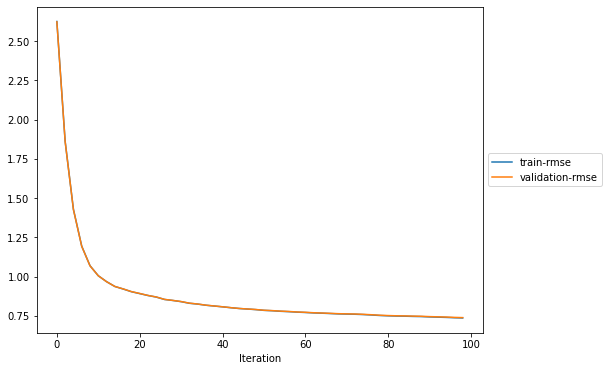

In [156]:
plot_collection(trial, "metrics")

In [157]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

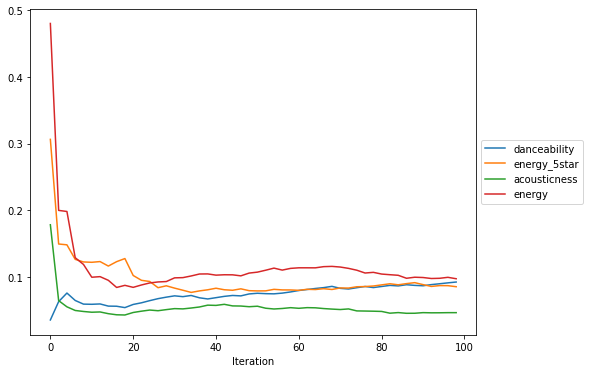

In [158]:
plot_feature_importance(trial, importance_type="gain")

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output. You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.

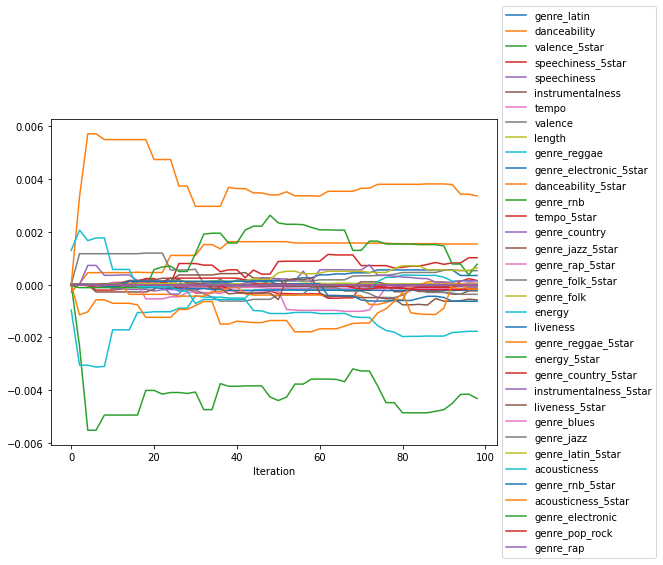

In [159]:
plot_collection(trial, "average_shap")

Global explanatory methods allow understanding the model and its feature contributions in aggregate over multiple datapoints. Here we show an aggregate bar plot that plots the mean absolute SHAP value for each feature.

In [162]:
!pip install shap

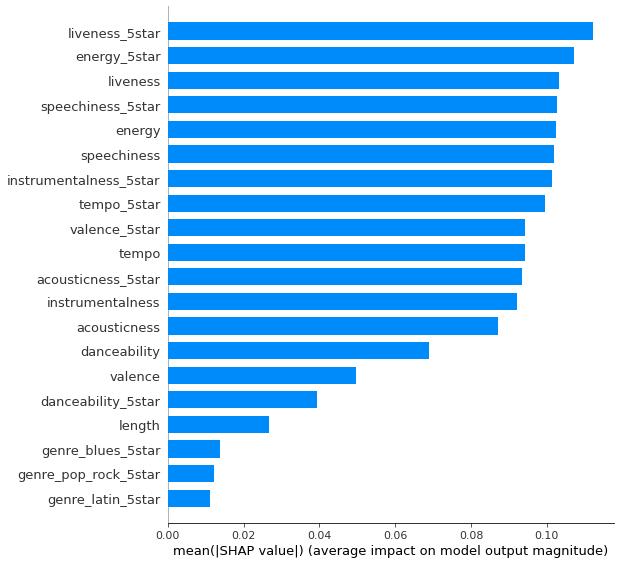

In [163]:
import shap

shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [164]:
shap_base_value

3.463822

The detailed summary plot below can provide more context over the above bar chart. It tells which features are most important and, in addition, their range of effects over the dataset. The color allows us to match how changes in the value of a feature effect the change in prediction.

The 'red' indicates higher value of the feature and 'blue' indicates lower (normalized over the features).

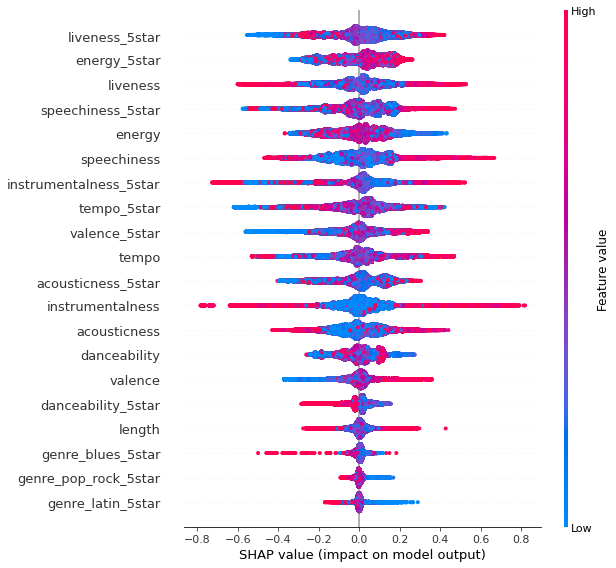

In [165]:
X_train = train.iloc[:, 1:]
shap.summary_plot(shap_no_base, X_train)

## SageMaker Model Monitor

### Enable real-time inference data capture

To enable data capture for monitoring the model data quality, you specify the new capture option called DataCaptureConfig. You can capture the request payload, the response payload or both with this configuration. The capture config applies to all variants. Please provide the Endpoint name in the following cell:

In [166]:
from sagemaker.model_monitor import DataCaptureConfig

# Please fill in the following for enabling data capture
s3_capture_upload_path = f"s3://{bucket}/{prefix}/endpoint-data-capture/"  # example: s3://bucket-name/path/to/endpoint-data-capture/

In [167]:
%%time
# Change parameters as you would like - adjust sampling percentage,
#  chose to capture request or response or both
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=25,
    destination_s3_uri=s3_capture_upload_path,
    kms_key_id=None,
    capture_options=["REQUEST", "RESPONSE"],
    csv_content_types=["text/csv"],
    json_content_types=["application/json"],
)

# Now it is time to apply the new configuration and wait for it to be applied
predictor.update_data_capture_config(data_capture_config=data_capture_config)
sess.wait_for_endpoint(endpoint=endpoint_name)

---------------!!CPU times: user 1.58 s, sys: 213 ms, total: 1.79 s
Wall time: 7min 35s


### Model Monitor - Baselining

In addition to collecting the data, SageMaker allows you to monitor and evaluate the data observed by the Endpoints. For this :
1. We need to create a baseline with which we compare the realtime traffic against. 
1. Once a baseline is ready, we can setup a schedule to continously evaluate/compare against the baseline.

### Constraint suggestion with baseline/training dataset

The training dataset with which you trained the model is usually a good baseline dataset. Note that the training dataset's data schema and the inference dataset schema should exactly match (i.e. number and order of the features).

Using our training dataset, we'll ask SageMaker to suggest a set of baseline constraints and generate descriptive statistics to explore the data.

In [168]:
##'s3://bucketname/path/to/baseline/data' - Where your validation data is
baseline_data_uri = val_data_uri
##'s3://bucketname/path/to/baseline/data' - Where the results are to be stored in
baseline_results_uri = f"s3://{bucket}/{prefix}/baseline/results"

print("Baseline data uri: {}".format(baseline_data_uri))
print("Baseline results uri: {}".format(baseline_results_uri))

Baseline data uri: s3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/data/val/val_data.csv
Baseline results uri: s3://sagemaker-us-east-1-390354360073/sagemaker-exp12061030/baseline/results


### Create a baselining job with the validation dataset

Now that we have the training data ready in S3, let's kick off a job to `suggest` constraints. `DefaultModelMonitor.suggest_baseline(..)` kicks off a `ProcessingJob` using a SageMaker provided Model Monitor container to generate the constraints. Please edit the configurations to fit your needs.

In [169]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

datetime_stamp = datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S")

my_default_monitor = DefaultModelMonitor(
    role=role,
    instance_count=2,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    base_job_name=f"{prefix}-monitor-{datetime_stamp}",
)

In [170]:
%%time

monitor_baseline = my_default_monitor.suggest_baseline(
    baseline_dataset=baseline_data_uri,
    dataset_format=DatasetFormat.csv(header=False),
    output_s3_uri=baseline_results_uri,
    job_name=f"{prefix}-monitor-baseline-{datetime_stamp}",
    wait=True,
)

Streaming output truncated to the last 5000 lines.
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 527
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 446
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 508
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 449
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 580
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 535
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 541
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 519
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 407
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 483
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 481
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 579
2022-06-12 12:22:41 INFO  ContextCleaner:54 - Cleaned accumulator 589
2022-06-12 12:22:41 INFO  ContextCleane

### Exploratory Analysis of the Processing Jobs underlying SageMaker Monitor
In this short section [next few cells] we will be showing you how to further view the underlying jobs for the monitoring job

In [174]:
def get_last_processing_job():

    response = sm_client.list_processing_jobs(
        NameContains=f"{prefix}-monitor-baseline-{datetime_stamp}",
        StatusEquals="Completed",
        SortBy="CreationTime",
        SortOrder="Descending",
        MaxResults=20,
    )
    pprint.pprint(response["ProcessingJobSummaries"][0])
    return response["ProcessingJobSummaries"][0]["ProcessingJobName"]

In [175]:
from sagemaker.processing import ProcessingJob
from sagemaker.estimator import Estimator
from sagemaker.model_monitor.model_monitoring import ModelMonitor

my_default_monitor_name = get_last_processing_job()

{'CreationTime': datetime.datetime(2022, 6, 12, 12, 17, 9, 189000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2022, 6, 12, 12, 24, 10, 761000, tzinfo=tzlocal()),
 'ProcessingEndTime': datetime.datetime(2022, 6, 12, 12, 24, 10, 267000, tzinfo=tzlocal()),
 'ProcessingJobArn': 'arn:aws:sagemaker:us-east-1:390354360073:processing-job/sagemaker-exp12061030-monitor-baseline-2022-06-12-121706',
 'ProcessingJobName': 'sagemaker-exp12061030-monitor-baseline-2022-06-12-121706',
 'ProcessingJobStatus': 'Completed'}


In [177]:
my_default_monitor_reload = ProcessingJob.from_processing_name(sess, my_default_monitor_name)

response = sm_client.describe_processing_job(ProcessingJobName=my_default_monitor_name)
pprint.pprint(response)

{'AppSpecification': {'ImageUri': '156813124566.dkr.ecr.us-east-1.amazonaws.com/sagemaker-model-monitor-analyzer'},
 'CreationTime': datetime.datetime(2022, 6, 12, 12, 17, 9, 189000, tzinfo=tzlocal()),
 'Environment': {'dataset_format': '{"csv": {"header": false, '
                                   '"output_columns_position": "START"}}',
                 'dataset_source': '/opt/ml/processing/input/baseline_dataset_input',
                 'output_path': '/opt/ml/processing/output',
                 'publish_cloudwatch_metrics': 'Disabled'},
 'ExitMessage': 'Completed: Job completed successfully with no violations.',
 'LastModifiedTime': datetime.datetime(2022, 6, 12, 12, 24, 10, 761000, tzinfo=tzlocal()),
 'ProcessingEndTime': datetime.datetime(2022, 6, 12, 12, 24, 10, 267000, tzinfo=tzlocal()),
 'ProcessingInputs': [{'AppManaged': False,
                       'InputName': 'baseline_dataset_input',
                       'S3Input': {'LocalPath': '/opt/ml/processing/input/baseline_dat

### Explore the generated constraints and statistics

In [178]:
baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(10)

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data,string_statistics.common.num_present,string_statistics.common.num_missing,string_statistics.distinct_count
0,_c0,Fractional,67202.0,0.0,3.461385,2.326120e+05,1.159148,1.000000,5.000000,"[{'lower_bound': 1.0, 'upper_bound': 1.4, 'cou...",0.64,2048.0,"[[2.0, 3.0, 3.0, 4.0, 4.0, 3.0, 3.0, 3.0, 5.0,...",NaN,NaN,NaN
1,_c1,Fractional,67202.0,0.0,250.195039,1.681361e+07,102.237315,4.000000,3024.000000,"[{'lower_bound': 4.0, 'upper_bound': 306.0, 'c...",0.64,2048.0,"[[111.0, 344.0, 268.0, 304.0, 289.0, 374.0, 32...",NaN,NaN,NaN
2,_c2,String,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67202.0,0.0,26863.0
3,_c3,String,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67202.0,0.0,22773.0
4,_c4,Fractional,67202.0,0.0,0.500310,3.362182e+04,0.255870,0.000000,0.989000,"[{'lower_bound': 0.0, 'upper_bound': 0.0989, '...",0.64,2048.0,"[[0.8663309091634099, 0.4243586375471675, 0.59...",NaN,NaN,NaN
5,_c5,Fractional,67202.0,0.0,0.066052,4.438854e+03,0.047981,0.022800,0.212000,"[{'lower_bound': 0.0228, 'upper_bound': 0.0417...",0.64,2048.0,"[[0.1347724793817437, 0.0677211032819893, 0.02...",NaN,NaN,NaN
6,_c6,String,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67202.0,0.0,19818.0
7,_c7,Fractional,67202.0,0.0,0.173251,1.164281e+04,0.116797,0.017400,0.601000,"[{'lower_bound': 0.0174, 'upper_bound': 0.0757...",0.64,2048.0,"[[0.0650071122945397, 0.3147217949277151, 0.33...",NaN,NaN,NaN
8,_c8,Fractional,67202.0,0.0,123.646789,8.309312e+06,29.368372,49.464000,218.991771,"[{'lower_bound': 49.464, 'upper_bound': 66.416...",0.64,2048.0,"[[103.34534244709566, 187.04773913881328, 115....",NaN,NaN,NaN
9,_c9,Fractional,67202.0,0.0,0.231689,1.556999e+04,0.088049,0.002478,0.449445,"[{'lower_bound': 0.0024777005028962, 'upper_bo...",0.64,2048.0,"[[0.3346254147389569, 0.2987936990726747, 0.23...",NaN,NaN,NaN


In [180]:
constraints_df = pd.json_normalize(
    baseline_job.suggested_constraints().body_dict["features"]
)
constraints_df.head(10)

,name,inferred_type,completeness,num_constraints.is_non_negative
0,_c0,Fractional,1.0,True
1,_c1,Fractional,1.0,True
2,_c2,String,1.0,NaN
3,_c3,String,1.0,NaN
4,_c4,Fractional,1.0,True
5,_c5,Fractional,1.0,True
6,_c6,String,1.0,NaN
7,_c7,Fractional,1.0,True
8,_c8,Fractional,1.0,True
9,_c9,Fractional,1.0,True


Before proceeding to enable monitoring, you could chose to edit the constraint file as required to fine tune the constraints.

### Enable continous monitoring

We have collected the data above, here we proceed to analyze and monitor the data with MonitoringSchedules.

In [181]:
from sagemaker.model_monitor import CronExpressionGenerator

mon_schedule_name = "music-rec-monitor-schedule-{}".format(
    datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S")
)
s3_report_path = f"s3://{bucket}/{prefix}/monitor/report"

try:
    my_default_monitor.create_monitoring_schedule(
        monitor_schedule_name=mon_schedule_name,
        endpoint_input=endpoint_name,
        output_s3_uri=s3_report_path,
        statistics=my_default_monitor.baseline_statistics(),
        constraints=my_default_monitor.suggested_constraints(),
        schedule_cron_expression=CronExpressionGenerator.daily(),
        enable_cloudwatch_metrics=True,
    )
    print(f"Created monitoring schedule {mon_schedule_name}")
except:
    my_default_monitor.update_monitoring_schedule(
        endpoint_input=endpoint_name,
        schedule_cron_expression=CronExpressionGenerator.daily(),
        enable_cloudwatch_metrics=True,
    )
    print(f"Updated monitoring schedule {my_default_monitor.monitoring_schedule_name}")

Created monitoring schedule music-rec-monitor-schedule-2022-06-12-122906


In [182]:
desc_schedule_result = my_default_monitor.describe_schedule()
while desc_schedule_result["MonitoringScheduleStatus"] != "Scheduled":
    print("Schedule status: {}".format(desc_schedule_result["MonitoringScheduleStatus"]))
    desc_schedule_result = my_default_monitor.describe_schedule()
    time.sleep(30)
print("Schedule status: {}".format(desc_schedule_result["MonitoringScheduleStatus"]))

Schedule status: Pending
Schedule status: Pending
Schedule status: Scheduled


![](https://drive.google.com/uc?id=1exl4WqlakWyb9ozzOvRYuKexwfRZ0cqC&authuser=recohut.data.001%40gmail.com&usp=drive_fs)

## Register Model with SageMaker Model Registry

Amazon SageMaker ML Lineage Tracking creates and stores information about the steps of a machine learning workflow from data preparation to model deployment. With the tracking information you can reproduce the workflow steps, track model and dataset lineage, and establish model governance and audit standards.

In [183]:
mpg_name = prefix + "-notebooks"

model_packages = sagemaker_client.list_model_packages(ModelPackageGroupName=mpg_name)[
    "ModelPackageSummaryList"
]

if model_packages:
    print(f"Using existing Model Package Group: {mpg_name}")
else:
    mpg_input_dict = {
        "ModelPackageGroupName": mpg_name,
        "ModelPackageGroupDescription": "Music Recommendation Models",
    }

    mpg_response = sagemaker_client.create_model_package_group(**mpg_input_dict)
    print(f"Create Model Package Group {mpg_name}: SUCCESSFUL")

Create Model Package Group sagemaker-exp12061030-notebooks: SUCCESSFUL


In [184]:
class InferenceSpecification:

    template = """
{    
    "InferenceSpecification": {
        "Containers" : [{"Image": "IMAGE_REPLACE_ME"}],
        "SupportedTransformInstanceTypes": INSTANCES_REPLACE_ME,
        "SupportedRealtimeInferenceInstanceTypes": INSTANCES_REPLACE_ME,
        "SupportedContentTypes": CONTENT_TYPES_REPLACE_ME,
        "SupportedResponseMIMETypes": RESPONSE_MIME_TYPES_REPLACE_ME
    }
}
"""

    def get_inference_specification_dict(self, ecr_image, supports_gpu, supported_content_types=None, supported_mime_types=None):
        return json.loads(self.get_inference_specification_json(ecr_image, supports_gpu, supported_content_types, supported_mime_types))

    def get_inference_specification_json(self, ecr_image, supports_gpu, supported_content_types=None, supported_mime_types=None):
        if supported_mime_types is None:
            supported_mime_types = []
        if supported_content_types is None:
            supported_content_types = []
        return self.template.replace("IMAGE_REPLACE_ME", ecr_image) \
            .replace("INSTANCES_REPLACE_ME", self.get_supported_instances(supports_gpu)) \
            .replace("CONTENT_TYPES_REPLACE_ME", json.dumps(supported_content_types)) \
            .replace("RESPONSE_MIME_TYPES_REPLACE_ME", json.dumps(supported_mime_types)) \

    def get_supported_instances(self, supports_gpu):
        cpu_list = ["ml.m4.xlarge","ml.m4.2xlarge","ml.m4.4xlarge","ml.m4.10xlarge","ml.m4.16xlarge","ml.m5.large","ml.m5.xlarge","ml.m5.2xlarge","ml.m5.4xlarge","ml.m5.12xlarge","ml.m5.24xlarge","ml.c4.xlarge","ml.c4.2xlarge","ml.c4.4xlarge","ml.c4.8xlarge","ml.c5.xlarge","ml.c5.2xlarge","ml.c5.4xlarge","ml.c5.9xlarge","ml.c5.18xlarge"]
        gpu_list = ["ml.p2.xlarge", "ml.p2.8xlarge", "ml.p2.16xlarge", "ml.p3.2xlarge", "ml.p3.8xlarge", "ml.p3.16xlarge"]

        list_to_return = cpu_list

        if supports_gpu:
            list_to_return = cpu_list + gpu_list

        return json.dumps(list_to_return)

In [185]:
model_uri = training_job_info.get("ModelArtifacts", {}).get("S3ModelArtifacts")
training_image = training_job_info["AlgorithmSpecification"]["TrainingImage"]

mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_image,
    supports_gpu=False,
    supported_content_types=["text/csv"],
    supported_mime_types=["text/csv"],
)

mp_inference_spec["InferenceSpecification"]["Containers"][0]["ModelDataUrl"] = model_uri
mp_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageDescription": "SageMaker Music Recommender",
    "ModelApprovalStatus": "PendingManualApproval",
}

mp_input_dict.update(mp_inference_spec)
mp_response = sagemaker_client.create_model_package(**mp_input_dict)

model_packages = sagemaker_client.list_model_packages(ModelPackageGroupName=mpg_name)[
    "ModelPackageSummaryList"
]
model_packages

[{'CreationTime': datetime.datetime(2022, 6, 12, 12, 39, 7, 646000, tzinfo=tzlocal()),
  'ModelApprovalStatus': 'PendingManualApproval',
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:390354360073:model-package/sagemaker-exp12061030-notebooks/1',
  'ModelPackageDescription': 'SageMaker Music Recommender',
  'ModelPackageGroupName': 'sagemaker-exp12061030-notebooks',
  'ModelPackageStatus': 'Completed',
  'ModelPackageVersion': 1}]

Create Model from Estimator

In [187]:
model_matches = sagemaker_client.list_models(NameContains=model_name)["Models"]

for model_name_match in model_matches:
    sagemaker_session.delete_model(model_name_match["ModelName"])
    print(f"Deleted existing model: {model_name_match['ModelName']}")

model = sess.create_model_from_job(
    name=model_name,
    training_job_name=training_job_name,
    role=role,
    image_uri=training_job_info["AlgorithmSpecification"]["TrainingImage"],
)

print(f"Created new model: {model_name}")

Created new model: music-rec-model-20220612-094437


That's all.

Thanks for your attention.